#### Linear Regression and Logistic Regression assigments are stacked, so the deadline for this homework is 10.10.21

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

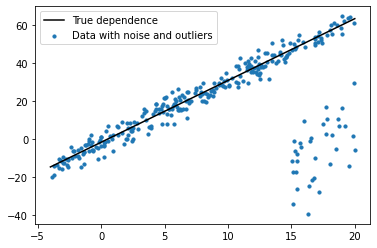

In [2]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

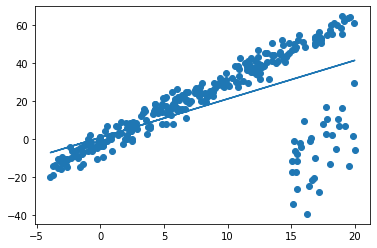

In [4]:
def hypothesis_function(x, theta_0, theta_1):
    y_pred = theta_0 + theta_1 * x
    return y_pred

def loss_function(x, y, theta_0, theta_1):
    loss = (hypothesis_function(x, theta_0, theta_1) - y) ** 2
    return loss

def cost_function(x, y, theta_0, theta_1):
    cost = 0
    m = len(x)
    for i in range(m):
        cost += loss_function(x[i], y[i], theta_0, theta_1)
    
    return cost / (1 * m)

def step_gradient(x, y, curr_theta_0, curr_theta_1, learning_rate):
    dTheta_0 = 0
    dTheta_1 = 0
    m = len(x)
    for i in range(m):
        dTheta_0 += (1/m) * (hypothesis_function(x[i], curr_theta_0, curr_theta_1) - y[i])
        dTheta_1 += (1/m) * x[i] * (hypothesis_function(x[i], curr_theta_0, curr_theta_1) - y[i])
        
    curr_theta_0 -= learning_rate * dTheta_0
    curr_theta_1 -= learning_rate * dTheta_1
    
    return curr_theta_0, curr_theta_1


def gradient_descent(x, y, theta_0, theta_1, learning_rate, num_iter):
    cost, theta_0_container, theta_1_container = [], [], []
    for i in range(num_iter):
        theta_0, theta_1 = step_gradient(x, y, theta_0, theta_1, learning_rate)
        cost.append(cost_function(x, y, theta_0, theta_1))
        theta_0_container.append(theta_0)
        theta_1_container.append(theta_1)
    
    return theta_0, theta_1, cost, theta_0_container, theta_1_container


def LinearRegression():
    theta_0 = np.random.random()
    theta_1 = np.random.random()
    num_iterations = 10000
    learning_rate = 0.0001
    theta_0, theta_1, cost, theta_0_container, theta_1_container = gradient_descent(X, 
                                                                                    y, 
                                                                                    theta_0, 
                                                                                    theta_1, 
                                                                                    learning_rate,
                                                                                    num_iterations)
    return theta_0, theta_1, cost, theta_0_container, theta_1_container


theta_0, theta_1, cost, theta_0_container, theta_1_container = LinearRegression()

lis = []
for i in X:
    lis.append(hypothesis_function(i, theta_0, theta_1))

plt.plot(X, lis)
plt.scatter(X, y)

## Task 2 (2 points + 1 bonus point + 1 super-bonus point)

(Titanic data again)

Build a model with `sklearn`'s `LogisticRegression` to get the accuracy of at least 0.80 (0.82 for the bonus point, 0.85 for the super-bonus point) on the test set.

Some (optional) suggestions:
- Add new features (e.g. missing value indicator columns)
- Fill missing values
- Encode categorical features (e.g. one-hot encoding)
- Scale the features (e.g. with standard or robust scaler)
- Think of other ways of preprocessing the features (e.g. `Fare` $\to$ `log(Fare)`)
- Try adding polynomial features



In [5]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2021/main/01-intro/train.csv

--2021-10-11 13:54:20--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2021/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.009s  

2021-10-11 13:54:20 (6.51 MB/s) - ‘train.csv’ saved [60302/60302]



In [6]:
import pandas as pd
data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### About the data
Here's some of the columns
* Name - a string with person's full name
* Survived - 1 if a person survived the shipwreck, 0 otherwise.
* Pclass - passenger class. Pclass == 3 is cheap'n'cheerful, Pclass == 1 is for moneybags.
* Sex - a person's gender
* Age - age in years, if available
* SibSp - number of siblings on a ship
* Parch - number of parents on a ship
* Fare - ticket cost
* Embarked - port where the passenger embarked
 * C = Cherbourg; Q = Queenstown; S = Southampton

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def feature_selection_and_preprocessing(dataset):
  # <YOUR CODE>
  # E.g.:
    features = dataset[["SibSp", "Parch", "Sex", "Pclass", "Age"]].copy()
    features["Age"] = dataset.Age.fillna(dataset.Age.median())
    features['Embarked'] = data.Embarked.fillna('unknown')
    return features

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(sparse=False), ['Embarked', 'Sex']),
        remainder='passthrough'
    ),
    LogisticRegression()
)


# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train, data_test = train_test_split(data, test_size=200, random_state=42)

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

train_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    )
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

print("Train accuracy:", accuracy_score(
    data_train['Survived'],
    train_predictions
))
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Train accuracy: 0.7973950795947902
Test accuracy: 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
